In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, top_bot_25, train, fit_rocket, fit_classifier
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff
# TODO: remove
from temp import find_best


eeg_data_1 = pd.read_csv('data/subject4/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject4/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject4/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject4/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject4/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject4/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

In [2]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, 
                      #eeg_data_2, 
                      eeg_data_3
                     ], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, 
                          #gradcpt_data_2,
                          gradcpt_data_3
                         ], ignore_index=True)

Gradcpt data had to be truncated


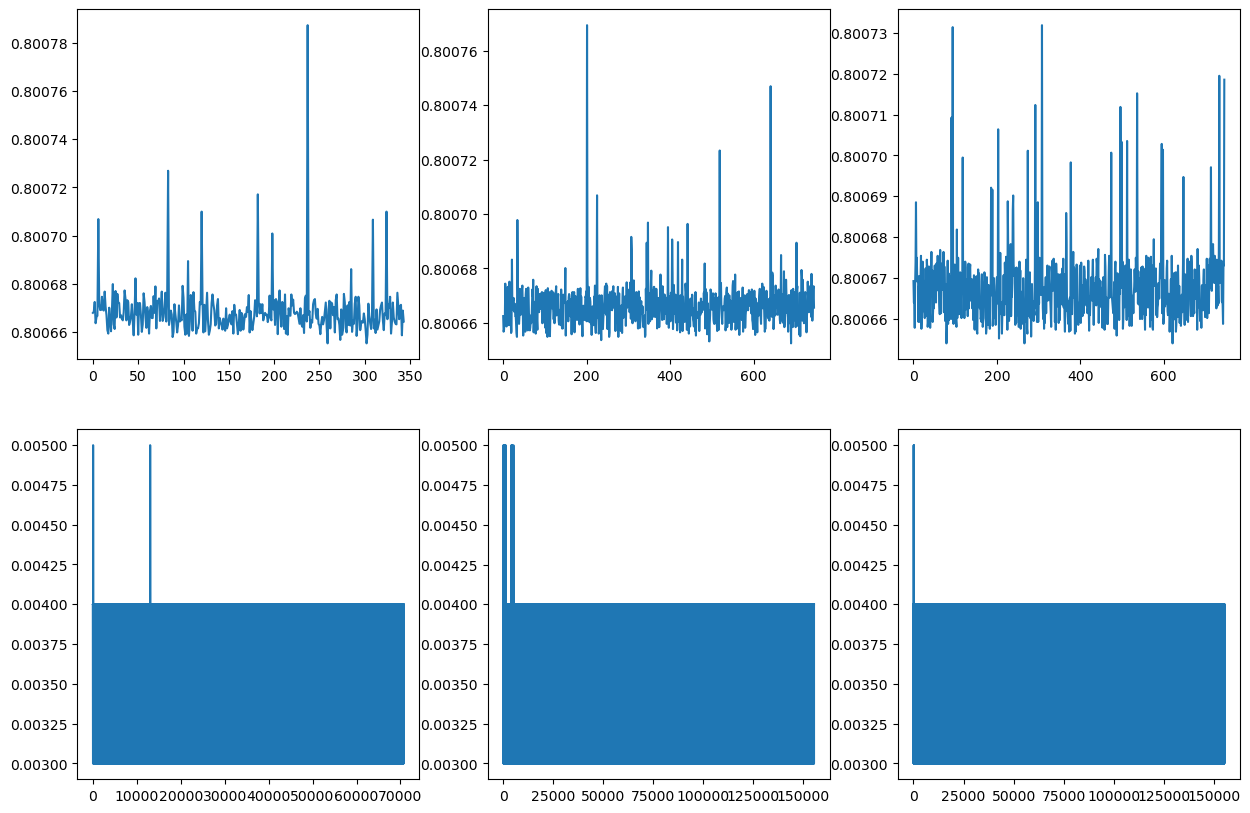

In [3]:
eeg_trials = [eeg_data_1, eeg_data_2, eeg_data_3]
gradcpt_trials = [gradcpt_data_1, gradcpt_data_2, gradcpt_data_3]
plot_sample_durations(eeg_trials, gradcpt_trials)

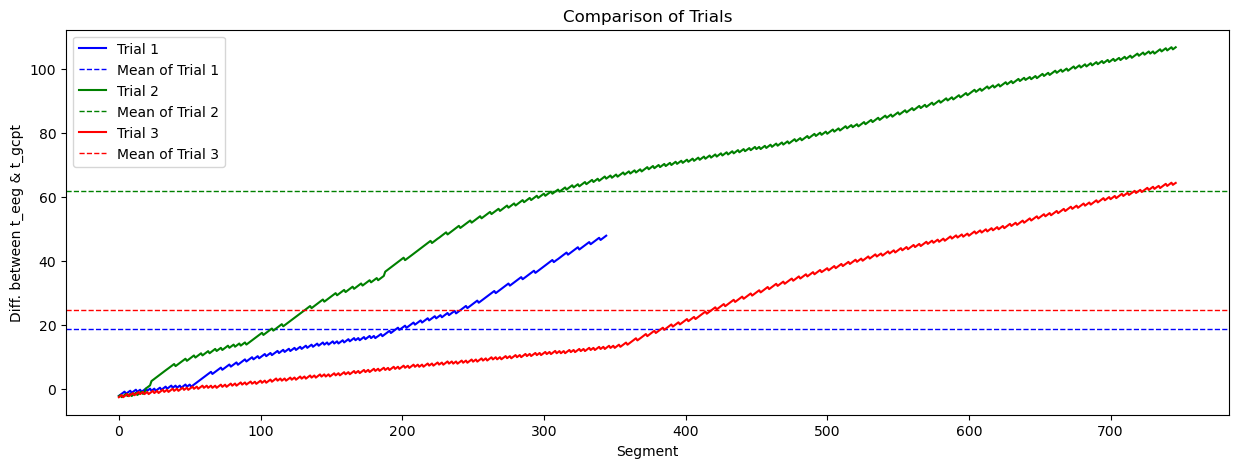

In [4]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### z-normalization

In [5]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Remove artifacts

In [6]:
for channel in channels:
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_normal'])

### Bandpass

In [7]:
for channel in channels:
    eeg_data[f'{channel}_bandpassed'] = bandpass(eeg_data[f'{channel}_artif_removed'])

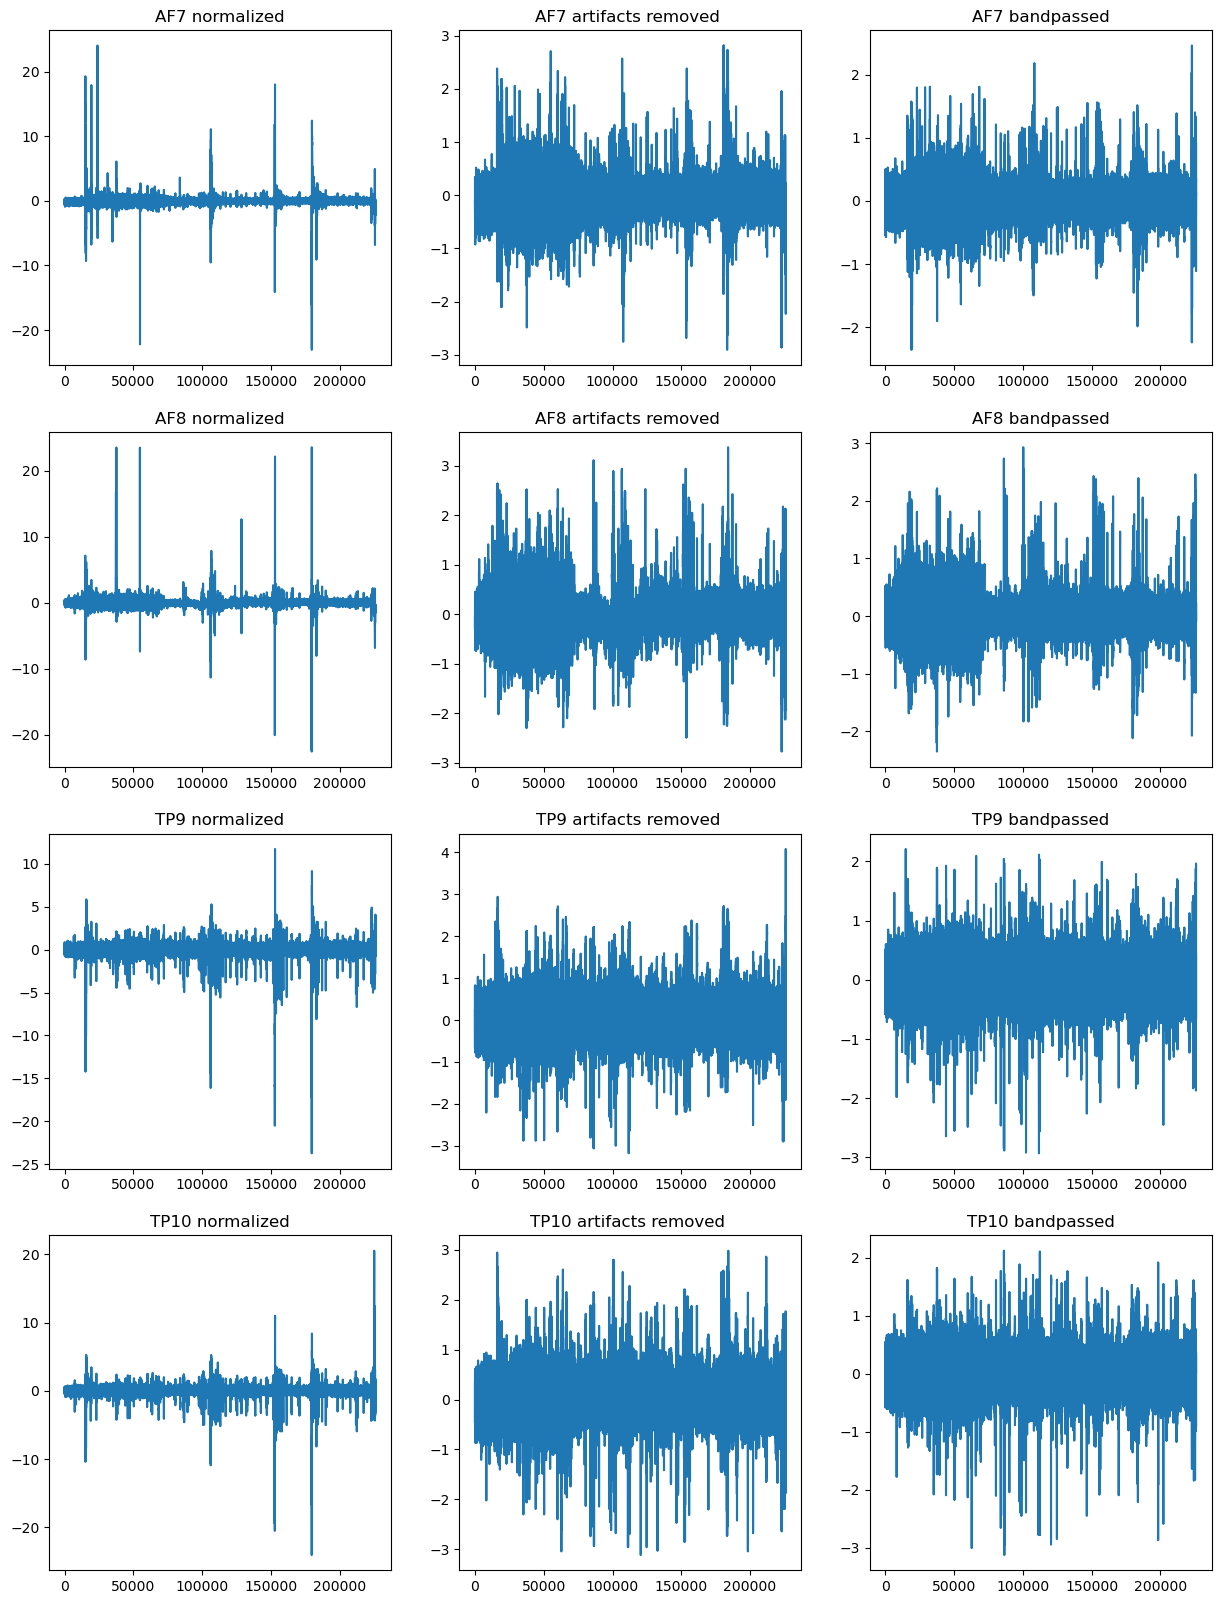

In [8]:
plot_preprocessing(channels=channels, eeg_df=eeg_data)

### Segment

In [9]:
all_channel_segments = []

# Process each channel
for channel in channels:
    # Segment the current EEG data for the channel
    channel_segments = segment_column(eeg_data[f'{channel}_bandpassed'], gradcpt_data)
    
    # Convert the list of segments into a numpy array with shape (number of segments, 205)
    # Not introducing the singleton dimension this time
    channel_segments_array = np.array(channel_segments).reshape(-1, 205)
    
    # Append the reshaped segments for this channel to the list
    all_channel_segments.append(channel_segments_array)

# Stack the channel segments along a new axis to combine them
# This should result in a shape: (number of segments, number of channels, 205)
combined_segments = np.stack(all_channel_segments, axis=1)
labels = np.array(gradcpt_data['in_the_zone'])

print(f"Corrected combined segments shape: {combined_segments.shape}")
print(f"Labels shape: {labels.shape}")

Corrected combined segments shape: (1092, 4, 205)
Labels shape: (1092,)


## Detach-ROCKET

### Combined features

In [10]:
X = combined_segments
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train_af7, X_test_af7 = X_train[:,0:1,:], X_test[:,0:1,:]
X_train_af8, X_test_af8 = X_train[:,1:2,:], X_test[:,1:2,:]
X_train_tp9, X_test_tp9 = X_train[:,2:3,:], X_test[:,2:3,:]
X_train_tp10, X_test_tp10 = X_train[:,3:4,:], X_test[:,3:4,:]

In [11]:
model_combined_features = fit_rocket(X_train, X_test, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 57.65%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 52.00
Train Accuraccy Detach Model: 84.16%
-------------------------
Test Accuraccy Full Model: 57.32%
Test Accuraccy Detach-ROCKET: 52.44%
-------------------------
Optimal Model Size: 6.94% of full model


In [12]:
X_train_transformed = model_combined_features.transform_features(X_train)
X_test_transformed = model_combined_features.transform_features(X_test)

In [13]:
fit_classifier(X_train_transformed, X_test_transformed, y_train, y_test);

Training Accuracy:
0.6379310344827587
Testing Accuracy:
0.5670731707317073

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.57      0.47      0.52        80
           1       0.57      0.65      0.61        84

    accuracy                           0.57       164
   macro avg       0.57      0.56      0.56       164
weighted avg       0.57      0.57      0.56       164


Confusion Matrix (Test):
 [[38 42]
 [29 55]]


In [14]:
find_best(X_train, X_test, y_train, y_test)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 57.22%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 57.00
Train Accuraccy Detach Model: 76.94%
-------------------------
######################
######################
new best at p=0.01
Training Accuracy:
0.5538793103448276
Testing Accuracy:
0.5548780487804879

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.54      0.55      0.55        80
           1       0.57      0.56      0.56        84

    accuracy                           0.55       164
   macro avg       0.55      0.55      0.55       164
weighted avg       0.56      0.55      0.55       164


Confusion Matrix (Test):
 [[44 36]
 [37 47]]
######################
######################
TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 56.68%
-------------------------
TRAINING RESULTS Detach

RidgeClassifier(alpha=4832.930238571752)

### Separate channels

### AF7

In [15]:
model_af7 = fit_rocket(X_train_af7, X_test_af7, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 68.64%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 40.00
Train Accuraccy Detach Model: 100.00%
-------------------------
Test Accuraccy Full Model: 53.66%
Test Accuraccy Detach-ROCKET: 49.39%
-------------------------
Optimal Model Size: 12.85% of full model


In [16]:
X_train_transformed_af7 = model_af7.transform_features(X_train_af7)
X_test_transformed_af7 = model_af7.transform_features(X_test_af7)

In [17]:
fit_classifier(X_train_transformed_af7, X_test_transformed_af7, y_train, y_test);

Training Accuracy:
0.7672413793103449
Testing Accuracy:
0.5182926829268293

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.51      0.41      0.46        80
           1       0.53      0.62      0.57        84

    accuracy                           0.52       164
   macro avg       0.52      0.52      0.51       164
weighted avg       0.52      0.52      0.51       164


Confusion Matrix (Test):
 [[33 47]
 [32 52]]


### AF8

In [18]:
model_af8 = fit_rocket(X_train_af8, X_test_af8, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 54555.95
Train Accuraccy Full ROCKET: 67.13%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 112.00
Train Accuraccy Detach Model: 58.62%
-------------------------
Test Accuraccy Full Model: 60.37%
Test Accuraccy Detach-ROCKET: 53.66%
-------------------------
Optimal Model Size: 0.31% of full model


In [19]:
X_train_transformed_af8 = model_af8.transform_features(X_train_af8)
X_test_transformed_af8 = model_af8.transform_features(X_test_af8)

In [20]:
fit_classifier(X_train_transformed_af8, X_test_transformed_af8, y_train, y_test);

Training Accuracy:
0.5474137931034483
Testing Accuracy:
0.573170731707317

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.59      0.40      0.48        80
           1       0.56      0.74      0.64        84

    accuracy                           0.57       164
   macro avg       0.58      0.57      0.56       164
weighted avg       0.58      0.57      0.56       164


Confusion Matrix (Test):
 [[32 48]
 [22 62]]


### TP9

In [21]:
model_tp9 = fit_rocket(X_train_tp9, X_test_tp9, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 58.08%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 52.00
Train Accuraccy Detach Model: 84.05%
-------------------------
Test Accuraccy Full Model: 54.88%
Test Accuraccy Detach-ROCKET: 50.61%
-------------------------
Optimal Model Size: 6.94% of full model


In [22]:
X_train_transformed_tp9 = model_tp9.transform_features(X_train_tp9)
X_test_transformed_tp9 = model_tp9.transform_features(X_test_tp9)

In [23]:
fit_classifier(X_train_transformed_tp9, X_test_transformed_tp9, y_train, y_test);

Training Accuracy:
0.6379310344827587
Testing Accuracy:
0.5792682926829268

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.58      0.51      0.54        80
           1       0.58      0.64      0.61        84

    accuracy                           0.58       164
   macro avg       0.58      0.58      0.58       164
weighted avg       0.58      0.58      0.58       164


Confusion Matrix (Test):
 [[41 39]
 [30 54]]


### TP10

In [24]:
model_tp10 = fit_rocket(X_train_tp10, X_test_tp10, y_train, y_test, graphic=False)

TRAINING RESULTS Full ROCKET:
Optimal Alpha Full ROCKET: 615848.21
Train Accuraccy Full ROCKET: 57.33%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 47.00
Train Accuraccy Detach Model: 87.39%
-------------------------
Test Accuraccy Full Model: 59.76%
Test Accuraccy Detach-ROCKET: 60.98%
-------------------------
Optimal Model Size: 8.97% of full model


In [25]:
X_train_transformed_tp10 = model_tp10.transform_features(X_train_tp10)
X_test_transformed_tp10 = model_tp10.transform_features(X_test_tp10)

In [26]:
fit_classifier(X_train_transformed_tp10, X_test_transformed_tp10, y_train, y_test);

Training Accuracy:
0.6379310344827587
Testing Accuracy:
0.5548780487804879

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.54      0.56      0.55        80
           1       0.57      0.55      0.56        84

    accuracy                           0.55       164
   macro avg       0.56      0.56      0.55       164
weighted avg       0.56      0.55      0.55       164


Confusion Matrix (Test):
 [[45 35]
 [38 46]]


### stacked

In [27]:
X_train_transformed_stacked = np.hstack((X_train_transformed_af7, X_train_transformed_af8, X_train_transformed_tp9, X_train_transformed_tp10))
X_test_transformed_stacked = np.hstack((X_test_transformed_af7, X_test_transformed_af8, X_test_transformed_tp9, X_test_transformed_tp10))

In [28]:
fit_classifier(X_train_transformed_stacked, X_test_transformed_stacked, y_train, y_test);

Training Accuracy:
0.8189655172413793
Testing Accuracy:
0.4878048780487805

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.47      0.46      0.47        80
           1       0.50      0.51      0.51        84

    accuracy                           0.49       164
   macro avg       0.49      0.49      0.49       164
weighted avg       0.49      0.49      0.49       164


Confusion Matrix (Test):
 [[37 43]
 [41 43]]
